In [96]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import NA, NaT

### Leer .csv pasanti

In [97]:
df_pasanti_sygnals=pd.read_csv("pasanti_sygnals.csv")

In [98]:
df_sygnals=df_pasanti_sygnals.copy()
df_sygnals.drop(columns="Unnamed: 0",inplace=True)

In [125]:
df_pasanti_sygnals["channel"].unique()

array(['Crypto Futures Spot Signals😘', '𝑪𝒐𝒊𝒏|𝑪𝒐𝒂𝒄𝒉|𝑺𝒊𝒈𝒏𝒂𝒍𝒔',
       'Bitcoin Bullets VIP Free', 'Federal Russian Insiders VIP Free'],
      dtype=object)

### Ajustar los tipos de datos

In [100]:
# determinar que tipo de datos hay en el data frame.
df_sygnals.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             1554 non-null   object 
 1   symbol                          1554 non-null   object 
 2   is_long                         1554 non-null   bool   
 3   is_entry_market                 1554 non-null   bool   
 4   entry_targets                   1554 non-null   object 
 5   take_profit_targets             1554 non-null   object 
 6   stop_targets                    1554 non-null   object 
 7   date                            1554 non-null   object 
 8   channel                         1554 non-null   object 
 9   channel_id                      1554 non-null   int64  
 10  message_link                    1554 non-null   object 
 11  dates_entry                     1544 non-null   object 
 12  dates_stoploss                  15

In [101]:
# convertir los datos tipo str a un typo de dato mas adecuado
df_sygnals=df_sygnals.convert_dtypes()

In [102]:
df_sygnals.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'entry_targets',
       'take_profit_targets', 'stop_targets', 'date', 'channel', 'channel_id',
       'message_link', 'dates_entry', 'dates_stoploss', 'dates_profit',
       'efficiency', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit'],
      dtype='object')

### ajustar los datos de fechas

In [103]:
# pasar los datos str a datetime
df_sygnals['date']=pd.to_datetime(df_sygnals['date'])

In [104]:
# extraer la primera fecha del conjunto de fechas.
def extrat(x):
  if type(x) == type(NA):
    return x
  if x == "False":
    return False
  if x == "never":
    return "never"
  else:
    return pd.to_datetime(x)


In [105]:
df_sygnals['first_dates_entry']=df_sygnals['first_dates_entry'].agg(lambda x: extrat(x))
df_sygnals['first_dates_stoploss']=df_sygnals['first_dates_stoploss'].agg(lambda x: extrat(x))
df_sygnals['first_dates_profit']=df_sygnals['first_dates_profit'].agg(lambda x: extrat(x))

## Calcular el tiempo transcurrido entre fechas

In [106]:
# crear un df con las columnas de tiempo
df_times=df_sygnals.loc[:,["date","first_dates_profit","first_dates_stoploss","first_dates_entry"]]
df_times

,date,first_dates_profit,first_dates_stoploss,first_dates_entry
0,2020-08-28 10:19:36,False,False,False
1,2020-09-14 07:10:46,False,False,False
2,2020-09-20 00:30:24,False,False,False
3,2020-09-23 07:41:41,False,False,False
4,2020-10-09 08:59:19,False,False,False
...,...,...,...,...
1549,2022-06-14 15:28:40,2022-06-15 14:45:00,never,2022-06-14 15:30:00
1550,2022-06-15 12:10:40,2022-06-15 14:40:00,never,2022-06-15 12:15:00
1551,2022-06-16 11:50:41,2022-06-20 06:10:00,never,2022-06-16 12:25:00
1552,2022-06-17 13:22:41,False,False,False


In [107]:
# funcion que calcula la diferencia entre dos fechas
def delta_time(d,e):
  d_e=False
  if type(e)==type(d) and type(e)!= bool and e is not NA:
    d_e=e-d
    d_e=d_e.total_seconds()
  return d_e

In [108]:
# nuevas columnas de diferencias entre fechas
df_times["d_e"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_entry),axis=1)
df_times["d_p"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_profit),axis=1)
df_times["e_p"]=df_times.agg(lambda x: delta_time(x.first_dates_entry,x.first_dates_profit),axis=1)
df_times["d_s"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_stoploss),axis=1)

In [109]:
pd.concat([df_times,df_sygnals[[""]]]

,date,first_dates_profit,first_dates_stoploss,first_dates_entry,d_e,d_p,e_p,d_s
0,2020-08-28 10:19:36,False,False,False,False,False,False,False
1,2020-09-14 07:10:46,False,False,False,False,False,False,False
2,2020-09-20 00:30:24,False,False,False,False,False,False,False
3,2020-09-23 07:41:41,False,False,False,False,False,False,False
4,2020-10-09 08:59:19,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
1549,2022-06-14 15:28:40,2022-06-15 14:45:00,never,2022-06-14 15:30:00,80.0,83780.0,83700.0,False
1550,2022-06-15 12:10:40,2022-06-15 14:40:00,never,2022-06-15 12:15:00,260.0,8960.0,8700.0,False
1551,2022-06-16 11:50:41,2022-06-20 06:10:00,never,2022-06-16 12:25:00,2059.0,325159.0,323100.0,False
1552,2022-06-17 13:22:41,False,False,False,False,False,False,False


In [110]:
# para ver los segundo en deltatime
str(timedelta(seconds=153229.7503816794))
str(timedelta(seconds=233928.42055084746))
str(timedelta(seconds=36378571.0))

'421 days, 1:09:31'

<AxesSubplot:>

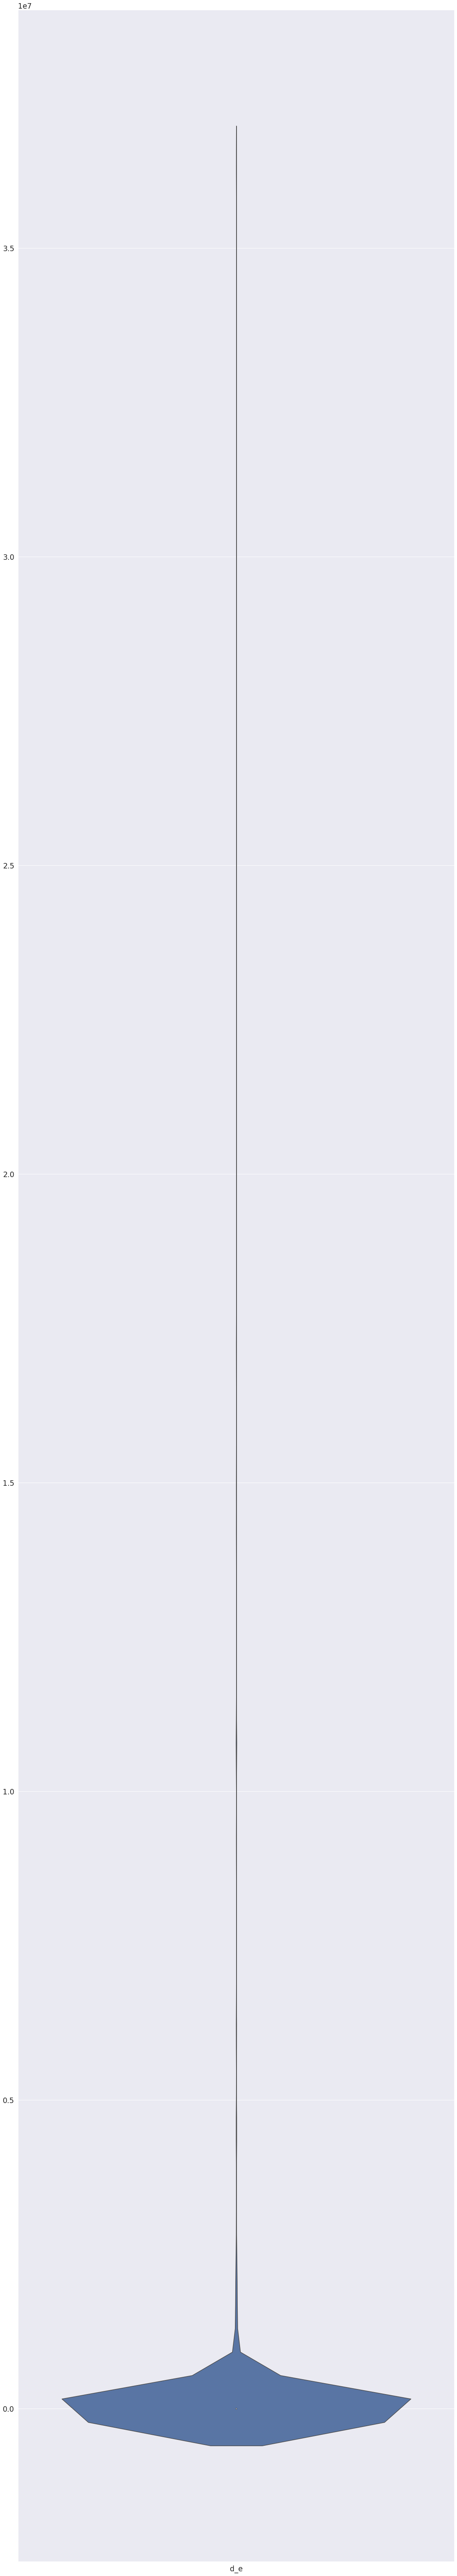

In [380]:
sns.set(rc={'figure.figsize':(20,120)},font_scale=1.7)
sns.violinplot(data=df_times[["d_e"]])

In [111]:
# Calcular los min, max, mena, median y mostrar en formato timedelta

pd.concat([
    (df_times[df_times["d_e"]!=False]["d_e"].agg([min,max,np.mean,np.median])).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["d_p"]!=False]["d_p"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["e_p"]!=False]["e_p"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["d_s"]!=False]["d_s"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
],axis=1)

,d_e,d_p,e_p,d_s
min,0:00:01,0:00:36,0:05:00,0:00:42
max,"421 days, 1:09:31","421 days, 1:09:31","45 days, 1:10:00","584 days, 7:21:29"
mean,"1 day, 18:37:44.046636","2 days, 17:02:56.488865",21:42:22.708333,"21 days, 16:48:22.957447"
median,0:07:42.500000,6:28:34,4:45:00,"5 days, 23:12:25"


# Cantidad de señales por canal

In [112]:
df_sygnals["channel"].replace(['𝑪𝒐𝒊𝒏|𝑪𝒐𝒂𝒄𝒉|𝑺𝒊𝒈𝒏𝒂𝒍𝒔','Crypto Futures Spot Signals😘'],["Coin|Coach|Signals","Crypto Futures Spot Signals"],inplace=True)

In [113]:
plt.rcParams["figure.figsize"] = (20,10)

<AxesSubplot:xlabel='channel', ylabel='Count'>

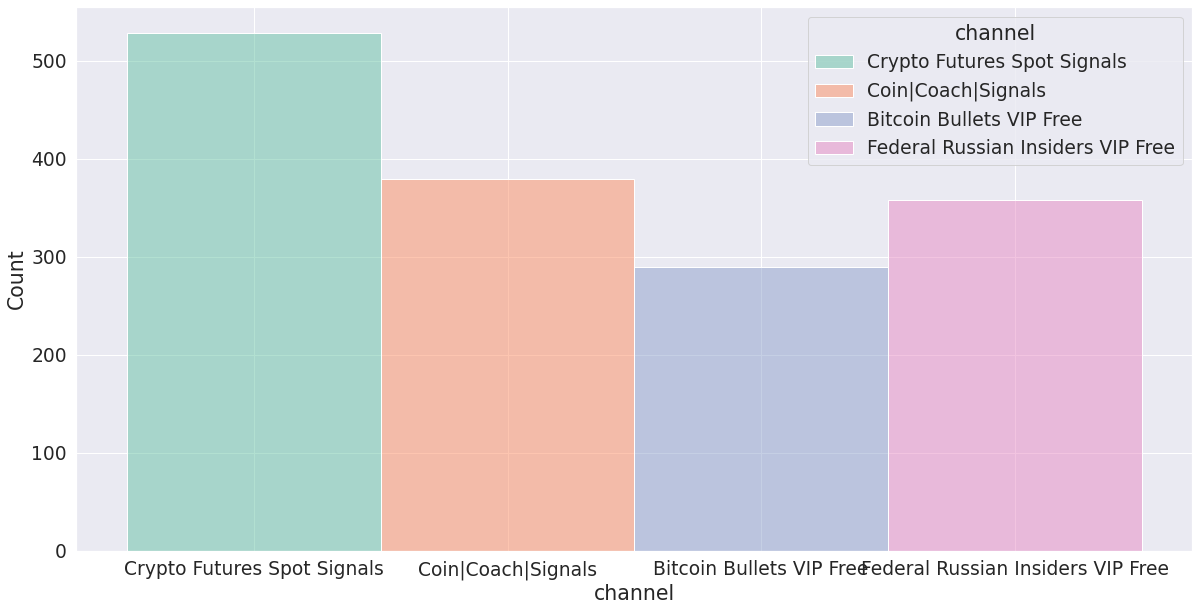

In [114]:
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.7)
sns.histplot(df_sygnals,x="channel",hue="channel" , palette="Set2")


## eficiencia de señales por canal

In [115]:
channels=df_sygnals["channel"].unique()
channels

<StringArray>
[      'Crypto Futures Spot Signals',                'Coin|Coach|Signals',
          'Bitcoin Bullets VIP Free', 'Federal Russian Insiders VIP Free']
Length: 4, dtype: string

In [116]:
efficiency_by_channel=df_sygnals[["channel","efficiency","symbol"]].groupby("channel")

Text(0.5, 1.0, 'Distribucion de eficiencia por canal')

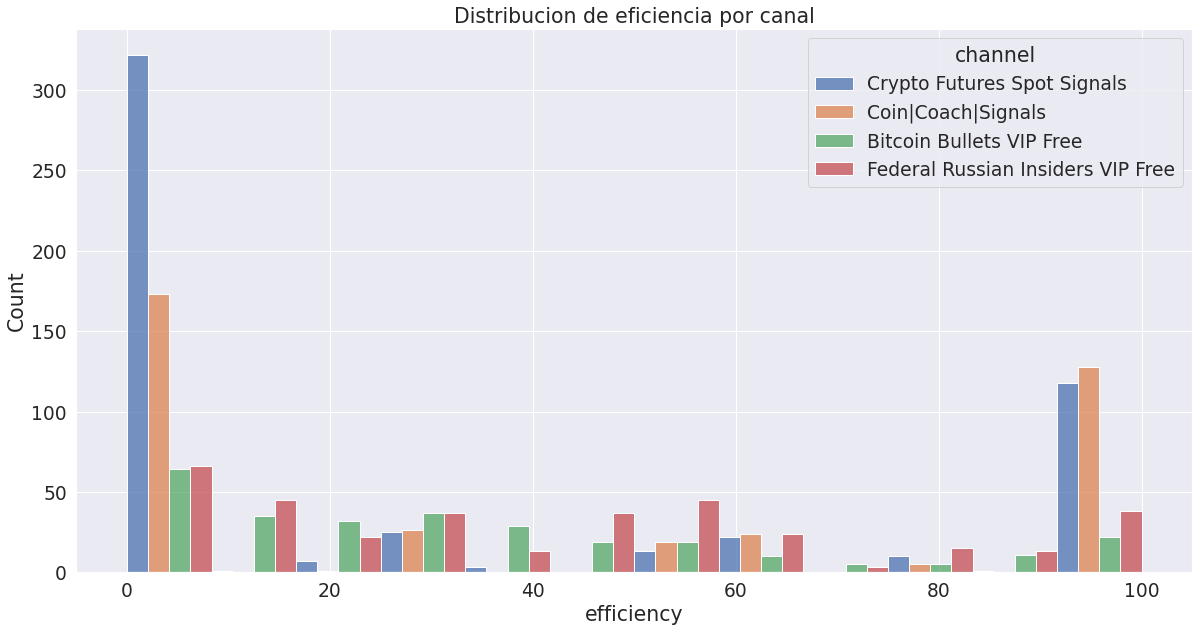

In [117]:
sns.histplot(df_sygnals, x='efficiency', hue = 'channel', multiple="dodge")
plt.title("Distribucion de eficiencia por canal")


Text(0.5, 1.0, 'Distribucion de eficiencia por canal')

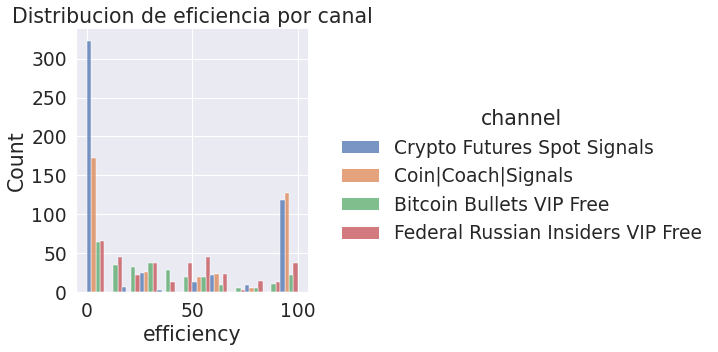

In [118]:
sns.displot(df_sygnals, x='efficiency', hue = 'channel', multiple="dodge")
plt.title("Distribucion de eficiencia por canal")

## Vistazo de cantidad de operaciones con ganancia y sin ganancia

In [119]:
is_profit:pd.Series=df_sygnals["efficiency"].dropna().agg(lambda x: "profit" if x > 0 else "no_profit")
is_profit.name="is_profit"

In [126]:
df_isprofit=pd.concat([df_sygnals[["efficiency","channel","symbol","_id"]],is_profit],axis=1)

Text(0.5, 1.0, 'Distribucion de profit por canal')

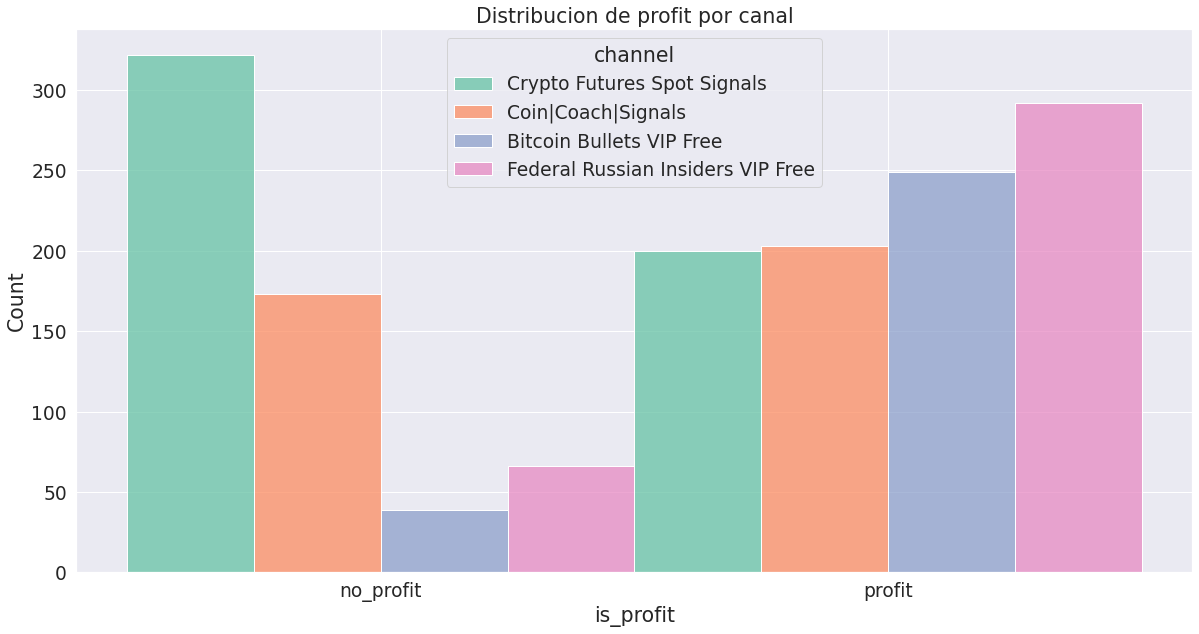

In [121]:
sns.histplot(df_isprofit, x='is_profit', hue = 'channel', multiple="dodge",palette="Set2")
plt.title("Distribucion de profit por canal")

## Cantidad de operaciones por criptomoneda

### Cantidad de symbolos y pares

In [129]:
df_sygnals["symbol"].unique()

<StringArray>
[  'BCHUSDT',   'ETHUSDT',   'BTCUSDT',  'BZRXUSDT',  'IOTAUSDT',  'YFIIUSDT',
   'RENUSDT',   'RSRUSDT',   'XRPUSDT',    'ONEBTC',
 ...
   'ANTUSDT',   'ANCUSDT', 'WAVESUSDT',   'BNXUSDT',   'GMTUSDT',  'DASHUSDT',
  'FLOWUSDT', 'JASMYUSDT',   'ENSUSDT',   'INJUSDT']
Length: 242, dtype: string

In [130]:
df_sygnals.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'entry_targets',
       'take_profit_targets', 'stop_targets', 'date', 'channel', 'channel_id',
       'message_link', 'dates_entry', 'dates_stoploss', 'dates_profit',
       'efficiency', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit'],
      dtype='object')

In [131]:
df_sygnals['primary_currencies'].unique()


<StringArray>
[   'BCH',    'ETH',    'BTC',   'BZRX',   'IOTA',   'YFII',    'REN',
    'RSR',    'XRP',    'ONE',
 ...
    'KSM',   'CTSI', 'PEOPLE',    'ANC',    'BNX',    'GMT',   'DASH',
   'FLOW',  'JASMY',    'ENS']
Length: 199, dtype: string

In [132]:
df_sygnals['segundary_currencies'].unique()


<StringArray>
['USDT', 'BTC']
Length: 2, dtype: string

In [ ]:
'Crypto Futures Spot Signals', 'Coin|Coach|Signals', 'Bitcoin Bullets VIP Free', 'Federal Russian Insiders VIP Free'

### 'Crypto Futures Spot Signals'

/tmp/ipykernel_5673/1730456425.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 208
cantidad por symbolo symbol
BTCUSDT    43
ETHUSDT    40
LTCUSDT    18
XRPUSDT    10
BNBUSDT    10
SOLUSDT     9
EOSUSDT     8
dtype: int64


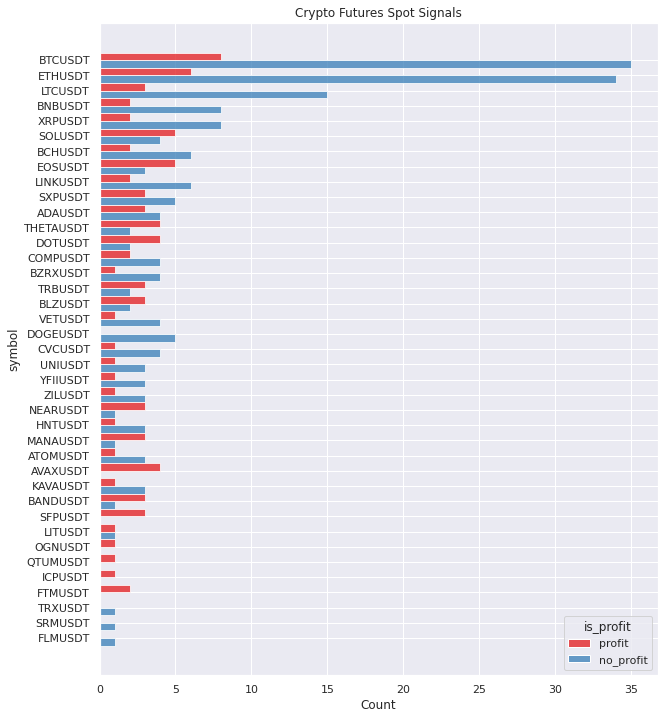

In [ ]:
#construir df para graficar

canal='Crypto Futures Spot Signals'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,12)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False).head(270), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")

plt.title(canal)

print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")


### 'Coin|Coach|Signals'

/tmp/ipykernel_5673/30060836.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 112
cantidad por symbolo symbol
BELUSDT      15
LITUSDT      12
BLZUSDT      11
NKNUSDT      10
ALPHAUSDT    10
CHZUSDT       9
FLMUSDT       9
dtype: int64


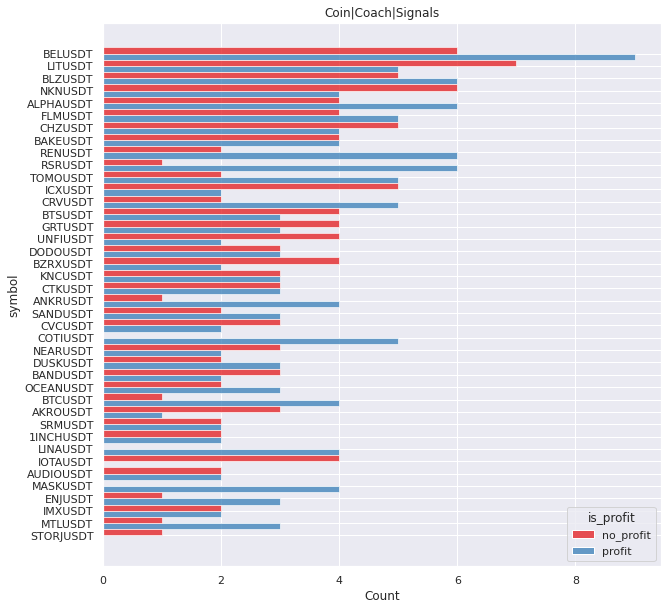

In [ ]:
#construir df para graficar

canal='Coin|Coach|Signals'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,10)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False).head(250), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")

plt.title(canal)

print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")

### 'Bitcoin Bullets VIP Free'

/tmp/ipykernel_5673/1788450536.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 65
cantidad por symbolo symbol
AVAXUSDT    17
LTCUSDT     15
ETHUSDT     14
DOTUSDT     11
BNBUSDT     11
DOGEUSDT    10
FILUSDT      9
dtype: int64


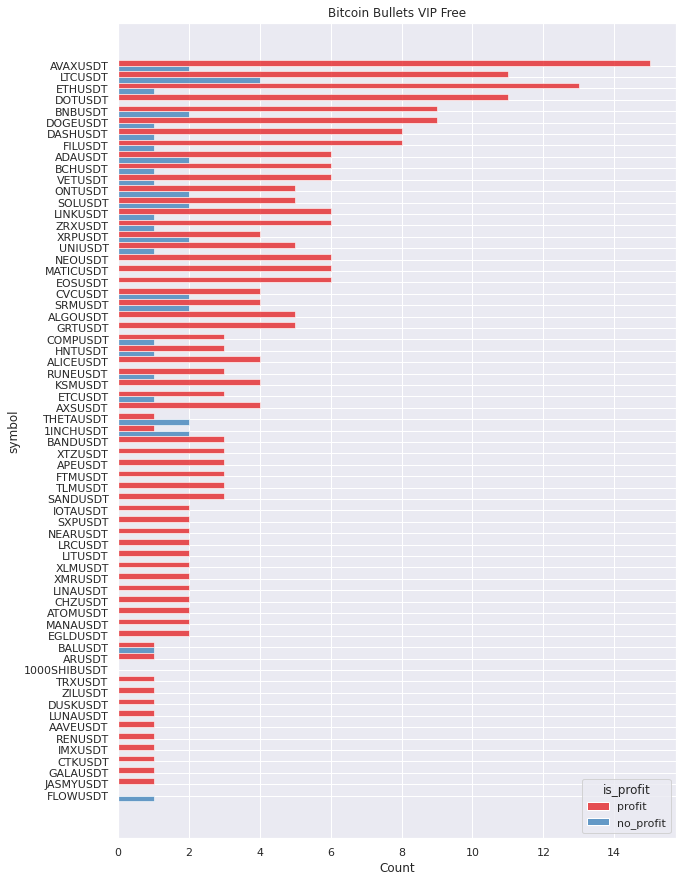

In [ ]:
#construir df para graficar

canal='Bitcoin Bullets VIP Free'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,15)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")

plt.title(canal)

print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")

### 'Federal Russian Insiders VIP Free'

/tmp/ipykernel_5673/1678940046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 68
cantidad por symbolo symbol
ETHUSDT    25
LTCUSDT    18
XRPUSDT    17
ZRXUSDT    14
EOSUSDT    14
XTZUSDT    14
ADAUSDT    13
dtype: int64


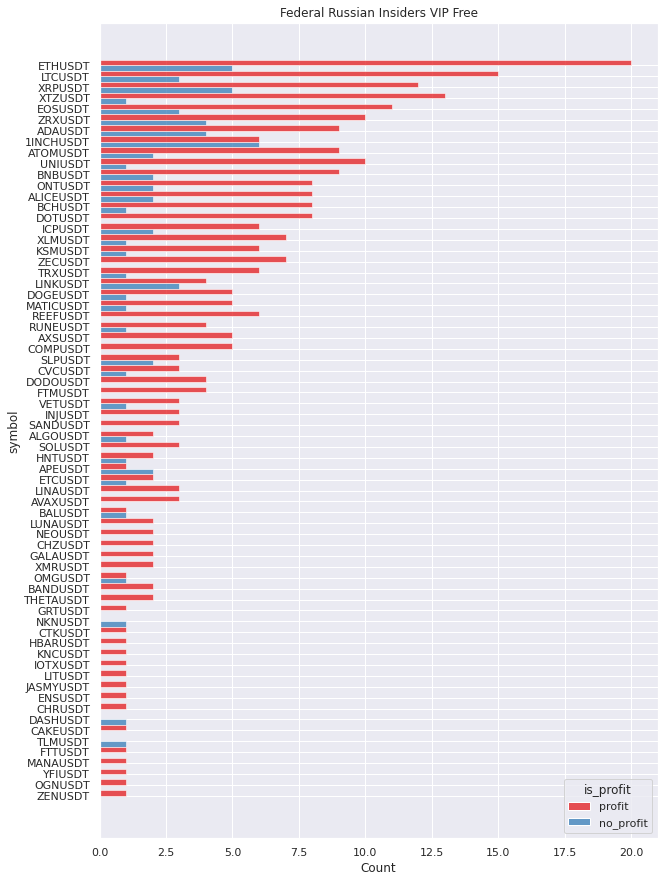

In [ ]:
#construir df para graficar

canal='Federal Russian Insiders VIP Free'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,15)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")

plt.title(canal)

print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")

Text(0.5, 1.0, 'Distribucion de profit por canal')

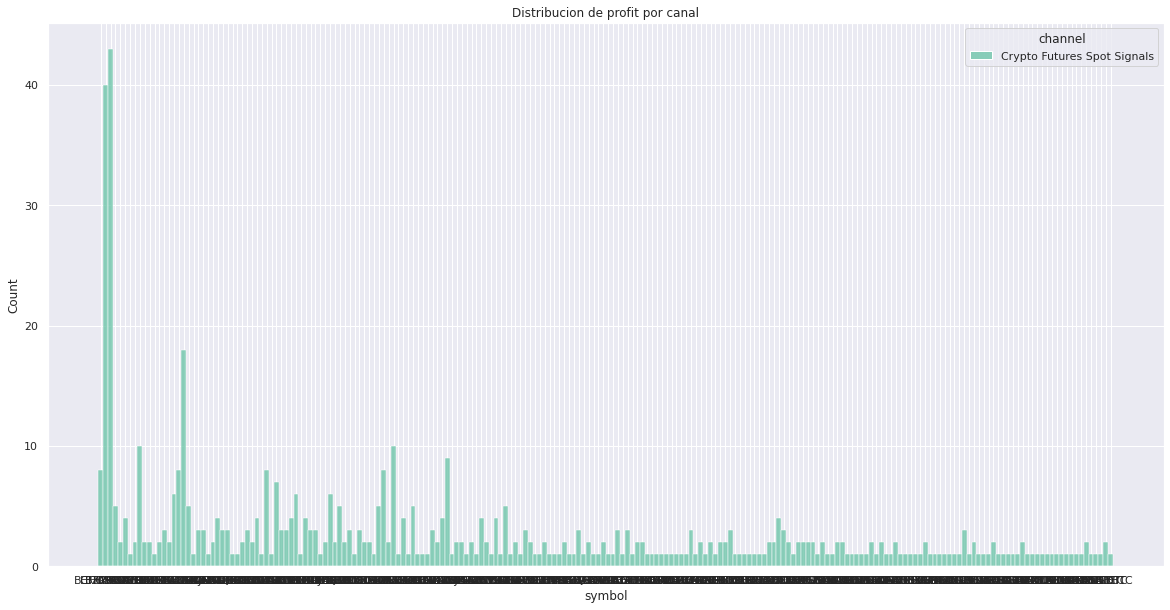

In [144]:
sns.histplot(profit_by_symbol.get_group('Crypto Futures Spot Signals'), x='symbol', hue = 'channel', multiple="dodge",palette="Set2")
plt.title("Distribucion de profit por canal")